In [93]:
import pandas as pd
# import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from nltk.tokenize import RegexpTokenizer
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from sklearn.feature_extraction import stop_words, text

%config InlineBackend.figure_format = 'retina'


In [94]:
data = pd.read_csv('./Datasets/qa_merged_df.csv')
data.head(2)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_score,answers_id,answers_author_id,answers_date_added,answers_body,answers_score
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,Teacher career question,What is a maths teacher? what is a ma...,1.0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,2016-04-29 19:40:14 UTC+0000,<p>Hi!</p>\n<p>You are asking a very interesti...,0.0
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,5.0,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,2018-05-01 14:19:08 UTC+0000,<p>Hi. I joined the Army after I attended coll...,0.0


#### General EDA on the dataframe

In [95]:
data.describe()

,questions_score,answers_score
count,51936.000000,51107.000000
mean,4.530980,0.415501
std,6.651972,0.921442
min,0.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,125.000000,30.000000


In [96]:
data.shape

(51944, 11)

In [97]:
data.dtypes

questions_id             object
questions_author_id      object
questions_date_added     object
questions_title          object
questions_body           object
questions_score         float64
answers_id               object
answers_author_id        object
answers_date_added       object
answers_body             object
answers_score           float64
dtype: object

Since our cleaning and EDA process was fluid and iterative there are a few artifacts for past iterations that need to be cleaned. Though these were cleaned in the cleaning data, this notebook is currently using "clean_w_sentiment.csv" an older version. We use this data because it provides the sentiment score which takes a while to process and calculating it on the newer data would take longer than allotted. Besides the few touch-ups, using this older version shouldn't negatively impact our EDA.

#### Changing dates to datetime data type

In [98]:
data['answers_date_added'] = pd.to_datetime(data['answers_date_added'])
data['questions_date_added'] = pd.to_datetime(data['questions_date_added'])

In [99]:
data['questions_date_added']

0       2016-04-26 11:14:26+00:00
1       2016-05-20 16:48:25+00:00
2       2016-05-20 16:48:25+00:00
3       2017-02-08 19:13:38+00:00
4       2017-09-01 14:05:32+00:00
                   ...           
51939   2016-05-28 03:08:07+00:00
51940   2015-10-21 20:16:38+00:00
51941   2015-10-21 20:16:38+00:00
51942   2015-10-21 20:16:38+00:00
51943   2015-10-21 20:16:38+00:00
Name: questions_date_added, Length: 51944, dtype: datetime64[ns, UTC]

#### Renaming 'qa_match' to 'was_answered' to match the column name in the tag EDA notebook and for clarity

In [100]:
data.rename(columns = {'qa_match':'was_answered'}, inplace=True)

#### Filling Nulls

I noticed there are still some null values, though we imputed some values in the cleaning notebook, we needed further EDA to understand how to impute nulls impacts the data. For now, we're just filling the 24 null values in `answers_body` with the string 'none'. Since this is such a small fraction of the data, it shouldn't have a significant impact on results.



In [101]:
data.isnull().sum()

questions_id              0
questions_author_id       0
questions_date_added      0
questions_title           0
questions_body            0
questions_score           8
answers_id              821
answers_author_id       821
answers_date_added      821
answers_body            822
answers_score           837
dtype: int64

#### Exploring `was_answered` - if the question was answered

An initial look at `was_answered` stats shows that the majority of questions are answered.

In [103]:
# data.groupby('was_answered')[['was_answered']].describe()

We can see that the average question score for where questions weren't answered was 0.75 and when answered 4.9 (the highest score is 125, with most between 0-10). The scores work similar to "upvotes" or "likes", 0 means 0 "upvotes", 5 means 5 "upvotes" etc. This intuitively makes sense, because questions with low or now upvotes are likely to go unanswered. 

The other thing to note is that the average answers_score is .45. Again, on the scale above, so it looks like the majority of answers aren't getting "upvotes". 


In [ ]:
# data.groupby('was_answered').mean()

The majority of questions are answered (1: answered, 0:not answered)

In [ ]:
# data['was_answered'].hist()
# plt.ylabel("Count");

In [ ]:
# qa_corr = data.drop(columns='tag_id').corr()[['was_answered']].dropna().sort_values('was_answered', ascending=False)

# sns.heatmap(qa_corr, annot=True);

### Exploring Sentiment Scores

In the NLP EDA notebook, I calculated the 'sentiment score' of the questions and answers body. I did this using the Natural Language Tool Kit (NLTK) library. The sentiment score parses through the text and awards words a positive or negative score. Words like "like", "love" "happy" etc. are attributed to a positive score, while "dislike", "annoyed" etc. are given negative scores. Words like "the", "it" etc. are considered neutral. NLTK then aggregates a score based on all the words in the passage. Though this is an imperfect approach (i.e. attributing a positive score to "don't like"  or the reverse), it provides a general understanding of the tone of the text. 

In the stats over below, grouped by 'was_answered', one can see that the average questions_score if relatively similar for questions that were answered and were not answered. Since not all the questions are answered, there are all 0's in the `answers_sentiment` score where `was_answered` is 0.

**The scores range from -1 to 1.** With 1 being positive, -1: negative.

In [ ]:
# data.groupby('was_answered')[['questions_sentiment', 'answers_sentiment']].describe()

#### Distribution of Answers Sentiment Scores:

The majority of `answers_sentiment` scores are close to 1, with a small bump just below 0. This is good and expected; the point of the platform is to empower and serve youth by answering their career questions. Negative sentiment scores would indicate that the professionals on the platform are not answering kindly, and should be flagged for investigation and possible removal from the platform. That said, humans are much better at discovering tone from the text, and should be reviewed manually or with further analysis before any action is taken.

In [143]:
# #Overall
# data['answers_sentiment'].hist(alpha=.5);
# plt.title('Answers Sentiment Score, range -1 to 1');
# plt.ylabel("Count")
# plt.xlabel("Sentiment Score");

#### Graphing Questions Sentiment Scores

Though there is a general trend for questions to have a positive sentiment score, we can see that the distribution of scores varies more than the answer scores.
## <span style ='color:red'> In further analysis, it'd be interesting to see how the sentiment score correlates to how quickly a question is answered.


In [142]:
# data['questions_sentiment'].hist(alpha=.5)
# plt.title('Questions Sentiment Score, range -1 to 1');
# plt.ylabel("Count")
# plt.xlabel("Sentiment Score");

## Exploring Answers Authors

We wanted to know more about who's answering the questions. Below we're looking at how many people are answering questions and how many questions they're answering.

The total number of unique authors is 10,169.

Out of x unique questions <span style = 'color:red'> (since the data is dirty, this isn't a true number).

<span style = 'color:red'> What tags are they answering. Is there a most popular tag? Are the tags they're answering part of their specialty. 

#### Checking the answers author Id's

In [104]:
data.groupby('answers_author_id').mean()

,questions_score,answers_score
answers_author_id,,
00009a0f9bda43eba47104e9ac62aff5,5.000,0.000000
000d4635e5da41e3bfd83677ee11dda4,4.000,0.000000
00271cc10e0245fba4a35e76e669c281,3.125,0.000000
003cc21be89d4e42bc4424131a378e86,3.500,0.000000
0046ab8089c04b3a8df3f8c28621a818,9.400,0.400000
...,...,...
ffdeaf7003a14c80aa237b35f6f636dc,4.000,2.000000
ffe2f26d5c174e13b565d026e1d8c503,3.500,0.333333
ffeaf7114b59443581b8acb5a9bfb38a,1.000,0.000000


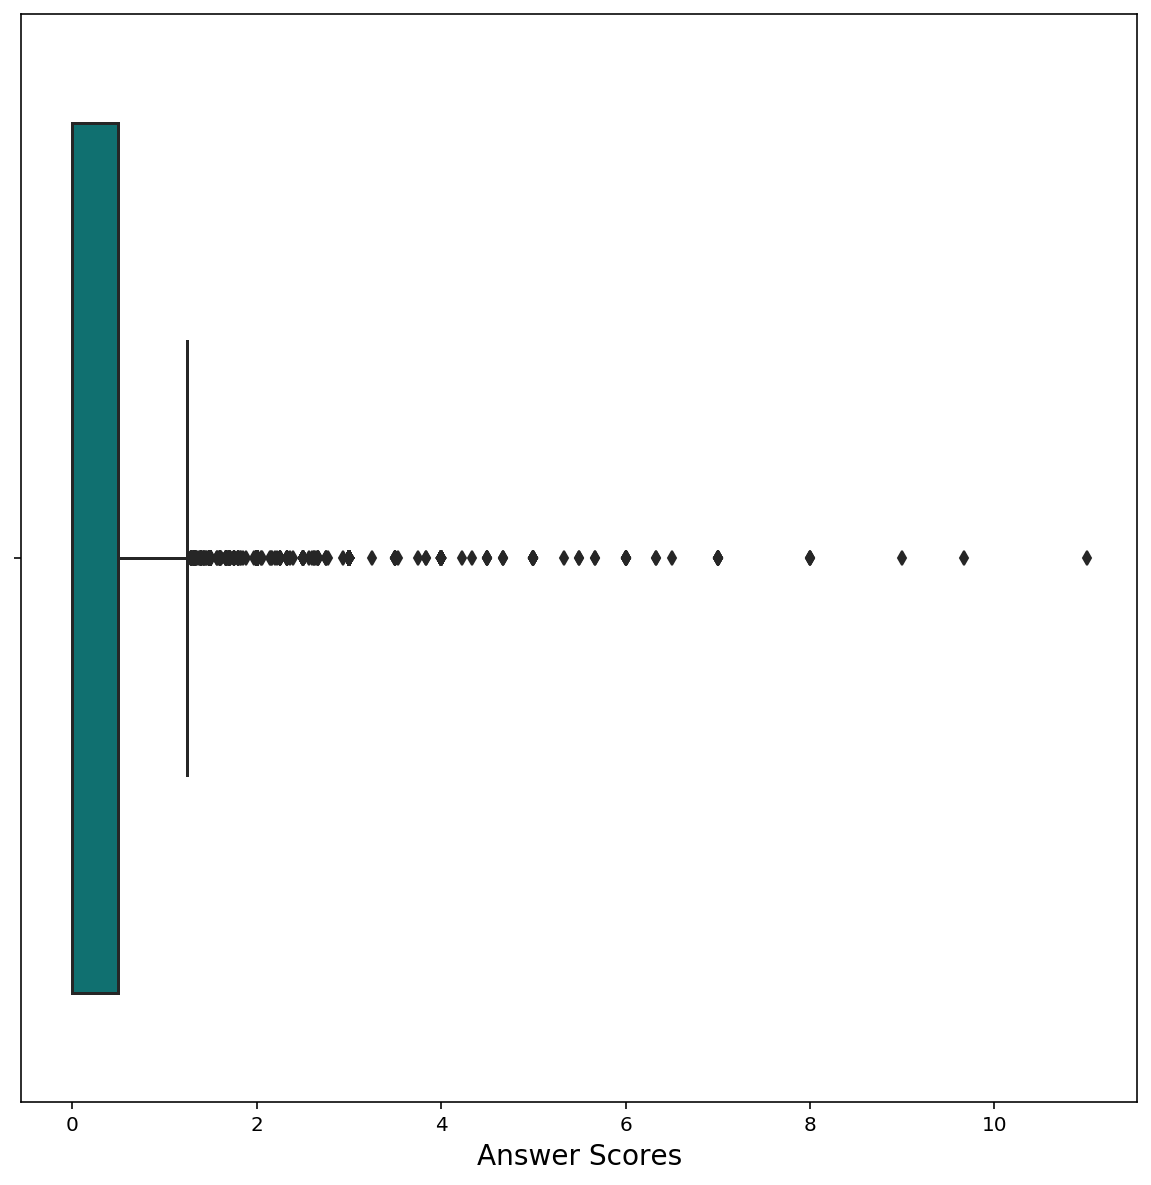

In [133]:
plt.figure(figsize=(10,10))
sns.boxplot(data.groupby('answers_author_id').mean()['answers_score'], color='teal');
plt.xlabel("Answer Scores", fontsize=14);

In looking at the initial stats above, I wanted to understand how many professionals had a high average answer score. Below are a few graphs outputs that look top average `answers_score`.

Authors with top 50 average `answer_scores`:

In [106]:
data.groupby('answers_author_id').mean().sort_values('answers_score', ascending=False).head(50)[['answers_score', 'questions_score']]

,answers_score,questions_score
answers_author_id,,
4dbdd4b99f80446798b3ab477f049285,11.000000,9.000000
1ec14aee9311480681dfa81b0f193de8,9.666667,15.666667
bdcdf938f015413fb3cb981836ca3dab,9.000000,24.000000
9ce1a6a0bb3c4cc49bc6414788b80c49,8.000000,6.000000
39a60344b603488ba9bb62c5c8b3be97,8.000000,14.000000
664a948f3d014b0d9251af1f0469c43e,8.000000,43.000000
5cbd4a64a328414781df8b75e47ffad3,7.000000,60.000000
64acecc36386468eae3bbb6f22c2aef9,7.000000,8.000000
f96c2cdbeb314deb911adcead45b4280,7.000000,5.000000


How many professionals had an average `answers_score` above 2.0? After some trial and error we can see that 319 out of 10169 professionals have an `answers_score` above 2.0

In [107]:
# Saving the professionals with the highest questions_score in a dataframe called: top_prof_df
top_prof_df = data.groupby('answers_author_id').mean().sort_values('answers_score', ascending=False).head(319)

# Viewing the professionals with the highest questions_score in a dataframe called: top_prof_df
data.groupby('answers_author_id').mean().sort_values('answers_score', ascending=False).head(320)[['answers_score', 'questions_score']]

,answers_score,questions_score
answers_author_id,,
4dbdd4b99f80446798b3ab477f049285,11.000000,9.000000
1ec14aee9311480681dfa81b0f193de8,9.666667,15.666667
bdcdf938f015413fb3cb981836ca3dab,9.000000,24.000000
9ce1a6a0bb3c4cc49bc6414788b80c49,8.000000,6.000000
39a60344b603488ba9bb62c5c8b3be97,8.000000,14.000000
...,...,...
55b940e77e854835b366a776d61b2fa2,2.000000,5.000000
61dce1c4c0a648fc9e04f7f5762e9210,2.000000,2.000000
88bcaee5379a47a48a655ed386a7bc41,2.000000,9.000000


How many professionals had average answers_score above 1.0? After some trial and error, we can see that 1017 out of 10169 professionals have answers_score above 1.0.

In [108]:
data.groupby('answers_author_id').mean().sort_values('answers_score', ascending=False).head(1020)[['answers_score', 'questions_score']]

,answers_score,questions_score
answers_author_id,,
4dbdd4b99f80446798b3ab477f049285,11.000000,9.000000
1ec14aee9311480681dfa81b0f193de8,9.666667,15.666667
bdcdf938f015413fb3cb981836ca3dab,9.000000,24.000000
9ce1a6a0bb3c4cc49bc6414788b80c49,8.000000,6.000000
39a60344b603488ba9bb62c5c8b3be97,8.000000,14.000000
...,...,...
2be67b772d294aeabee603c5eaa98669,1.000000,4.000000
e97d7f0c31954288a592863e977569ea,1.000000,12.000000
2bc49eecdab6499293afd40d19503b14,1.000000,3.500000


### Exploring Scores

Below is a look at the general stats, grouped by `was_answered` for question and answer scores. Unsurprisingly the average question score for questions that were answered is several points higher than wasn't answered. That said, it's interesting to see that the average score for questions that weren't answered was above 0, or almost zero. In looking at the max `question_score` for questions that weren't answered, we see a question had 123 "upvotes" and still wasn't answered. This is an anomaly, but interesting. 

#### General Stats for Question and Answer Scores:

In [141]:
# data.groupby('was_answered')[['questions_score', 'answers_score']].describe()

### Exploring `answer_scores`

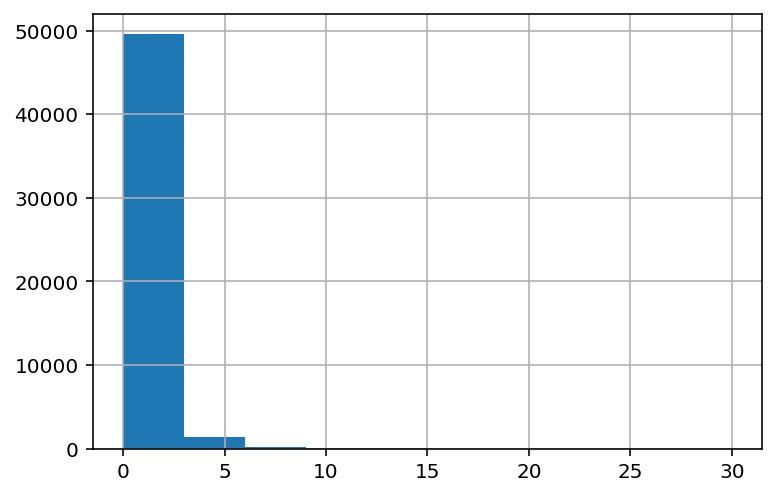

In [111]:
data['answers_score'].hist();

There are 23 unique values for answer scores

In [112]:
data['answers_score'].nunique()

23

Below outputs the frequency for how often each answer score value occurs:

In [113]:
data['answers_score'].value_counts()

0.0     37286
1.0      9607
2.0      2655
3.0       852
4.0       362
5.0       158
6.0        67
7.0        45
8.0        28
9.0        13
10.0        8
12.0        7
11.0        5
13.0        3
14.0        3
22.0        1
19.0        1
18.0        1
20.0        1
30.0        1
25.0        1
17.0        1
15.0        1
Name: answers_score, dtype: int64

Similar to above, below graphs the frequency for how often each answer score value occurs:

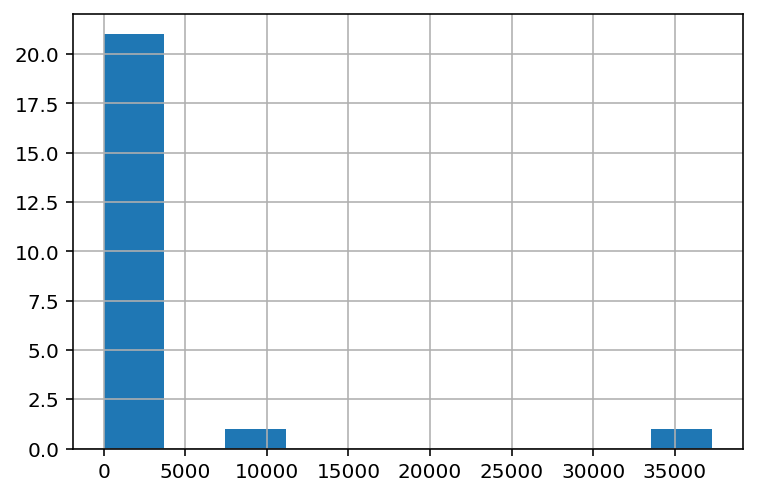

In [114]:
data['answers_score'].value_counts().hist();

Taking a closer look at the general stats, distribution, and quartiles for answer_scores:

In [115]:
data['answers_score'].describe()

count    51107.000000
mean         0.415501
std          0.921442
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         30.000000
Name: answers_score, dtype: float64

The boxplot provides a good visual for how the answer scores and spread. The majority of scores are between 0 and 1. With outliers above about 2. Since there can't be negative scores, there are no outliers to the left of the graph.

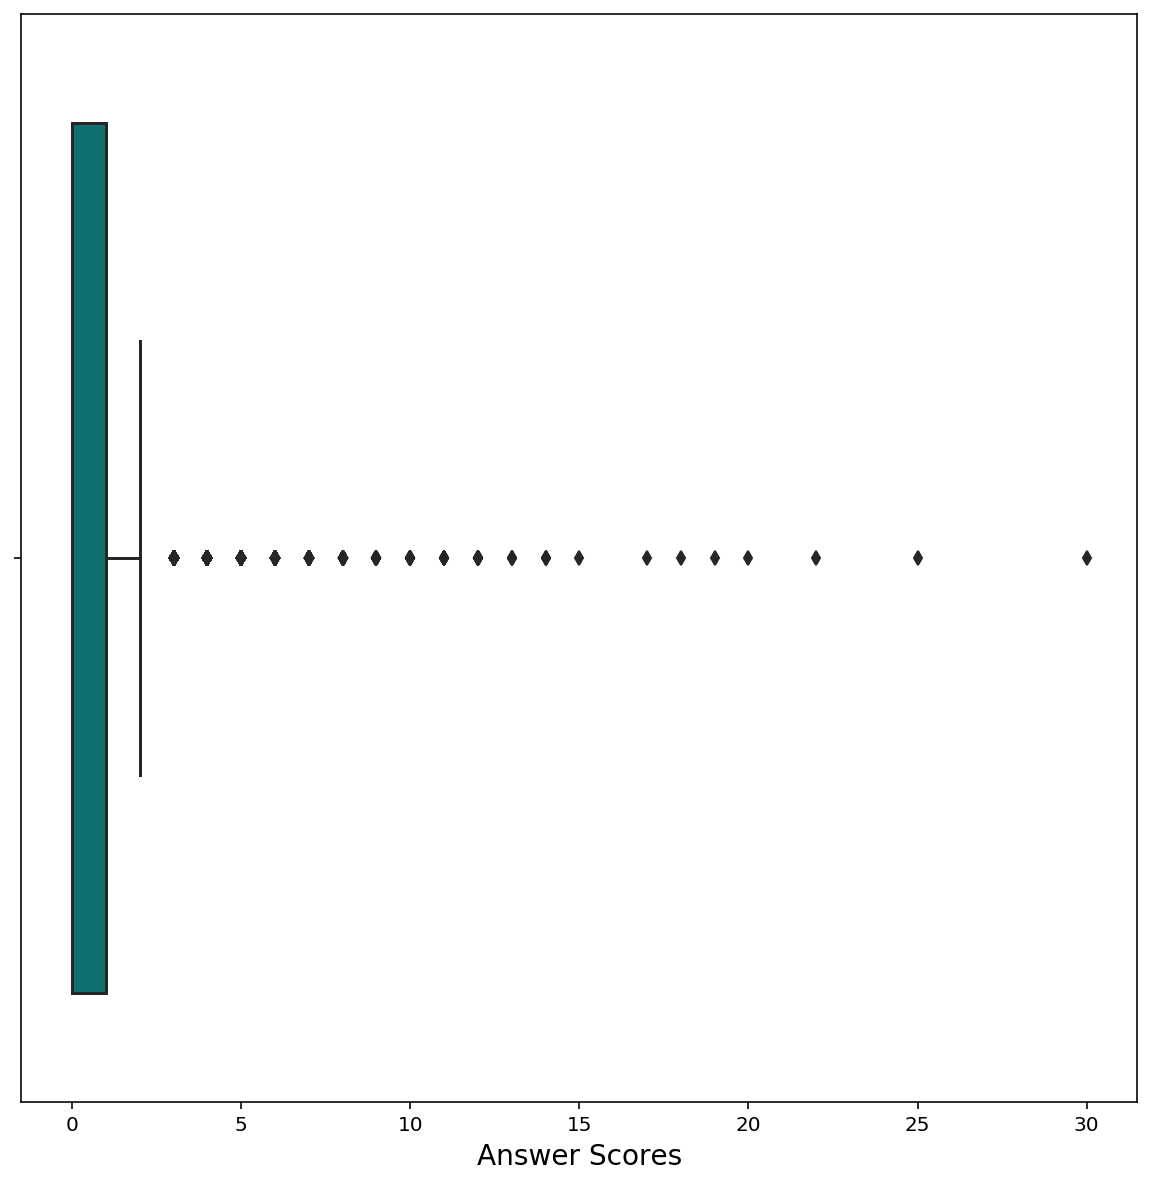

In [134]:
plt.figure(figsize=(10,10))
sns.boxplot(data['answers_score'], color='teal');
plt.xlabel("Answer Scores", fontsize=14);

### Exploring `questions_score`

There are 75 unique question scores

In [117]:
data['questions_score'].nunique()

75

Taking a closer look at the general stats, distribution, and quartiles for answer_scores:

In [118]:
data['questions_score'].describe()

count    51936.000000
mean         4.530980
std          6.651972
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        125.000000
Name: questions_score, dtype: float64

The boxplot provides a good visual for how the question scores and spread. The majority of scores are between 2 and 4. With outliers above about 9. 

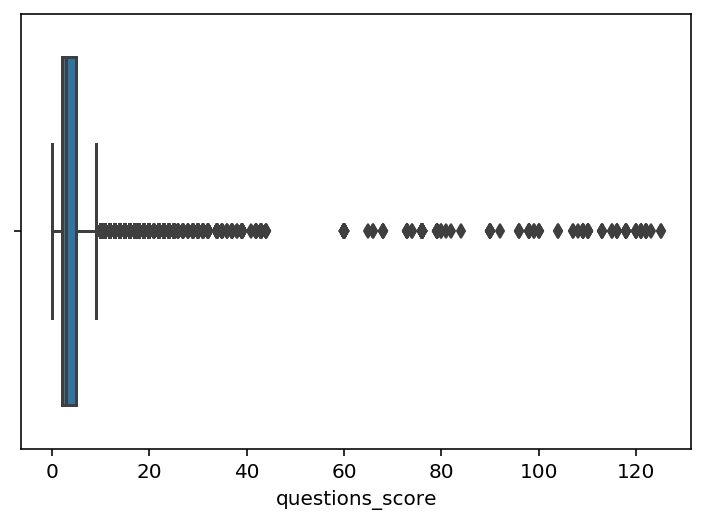

In [119]:
sns.boxplot(data['questions_score']);

A deeper dive into the distribution of `questions_scores` shows just how many of the scores are between 0-5, and how few are above 5.

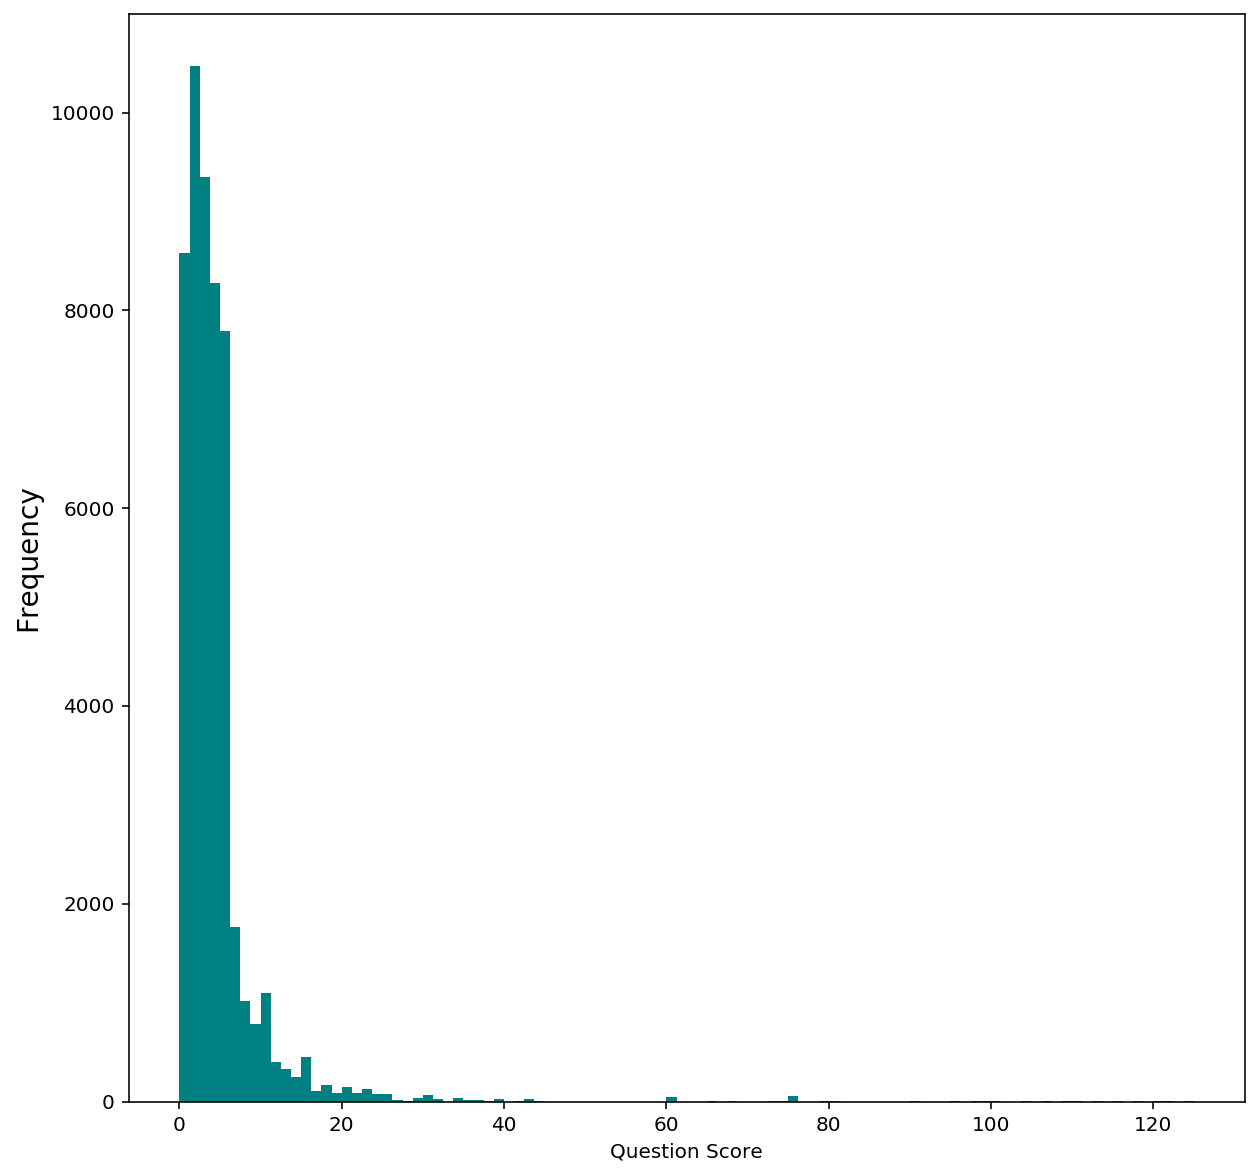

In [140]:
plt.figure(figsize=(10,10))
data['questions_score'].plot(kind='hist', bins=100, color='teal');
plt.ylabel("Frequency", size=14)
plt.xlabel("Question Score");

#### Exploring dates and lengths of time answered

Creating a column called `time_to_answer` that is a calculation of the `answers_date_added` minus `questions_date_added` columns. The data is in date-time units.

In [121]:
data['time_to_answer'] = data['answers_date_added'] - data['questions_date_added']

# [x.strftime("%Y-%m-%d %H:%M:%S") for x in data['time_to_answer']]
data.head(2)

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_score,answers_id,answers_author_id,answers_date_added,answers_body,answers_score,time_to_answer
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26+00:00,Teacher career question,What is a maths teacher? what is a ma...,1.0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,2016-04-29 19:40:14+00:00,<p>Hi!</p>\n<p>You are asking a very interesti...,0.0,3 days 08:25:48
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25+00:00,I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...,5.0,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,2018-05-01 14:19:08+00:00,<p>Hi. I joined the Army after I attended coll...,0.0,710 days 21:30:43


In [122]:
data[['time_to_answer']].head()

,time_to_answer
0,3 days 08:25:48
1,710 days 21:30:43
2,711 days 09:52:37
3,90 days 23:47:09
4,42 days 08:02:01


General stats for how long it takes for a question to be answered. As we can see here that the mean is 142 days, while the median is 22 days. The average is heavily skewed by the max amount of days it took to answer a question; 2,562, which is about 7 years. This is highly suspicious that a question took 7 years to be answered. Additionally, the min is negative, and an answer to a question can't be posted before it was asked. Since the data was likely auto-generated from the site, it's unlikely it's an imputation error. It may be a merging error due to how messy the data has been in general. The other possibility is that if an answer was posted for a different similar question, it might be linked to the new question (this would have to be confirmed by careervillage.com).

In [123]:
# data[data['was_answered'] ==1][['time_to_answer']].describe()

In [124]:
# data[data['was_answered'] ==1][['time_to_answer']].sort_values('time_to_answer')

In [125]:
data[['time_to_answer']].mean()

time_to_answer   139 days 02:32:34.330927
dtype: timedelta64[ns]

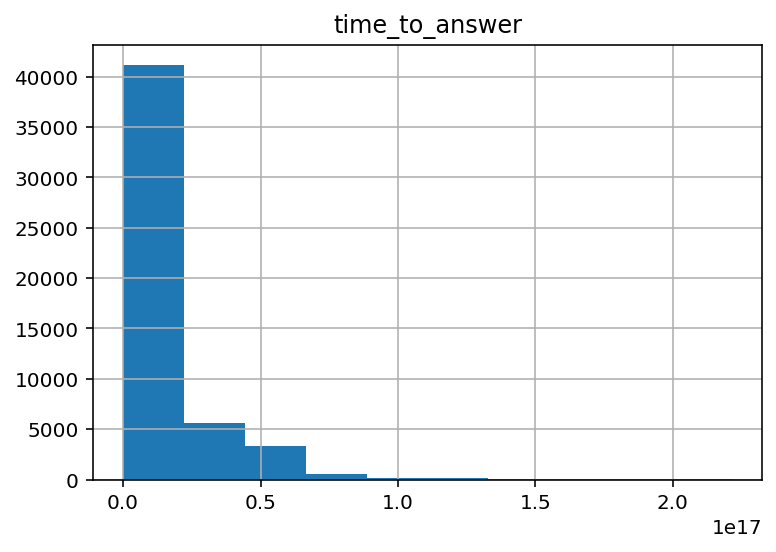

In [126]:
time_nulless = data[['time_to_answer']].dropna().astype(int)
time_nulless.hist();

## Exporting Data

In [ ]:
# data.to_csv('./Datasets/cleaned_w_sentiment.csv', index=False)